In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0984 - mae: 0.2533 - val_loss: 0.0270 - val_mae: 0.1613
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - mae: 0.0683 - val_loss: 0.0019 - val_mae: 0.0343
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040 - mae: 0.0474 - val_loss: 0.0017 - val_mae: 0.0325
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mae: 0.0436 - val_loss: 0.0012 - val_mae: 0.0273
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - mae: 0.0494 - val_loss: 0.0038 - val_mae: 0.0556
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mae: 0.0465 - val_loss: 0.0016 - val_mae: 0.0312
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0036 - mae: 0.0451 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - mae: 0.0385 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 -

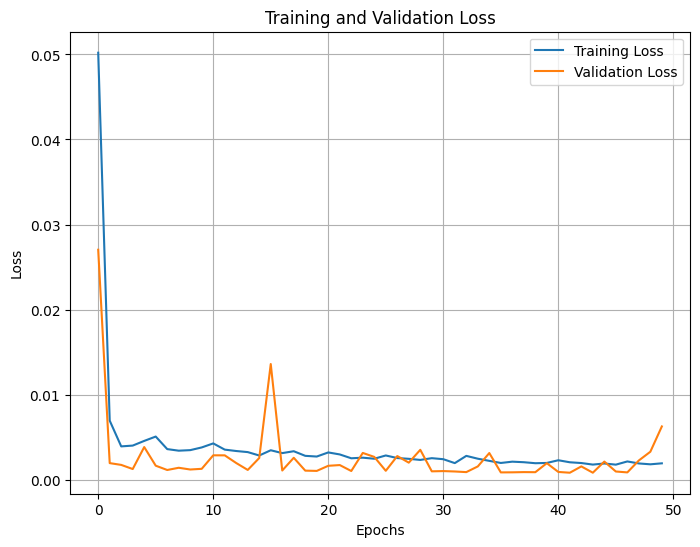

Model saved as 'google_stock_lstm_with_validation.h5'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


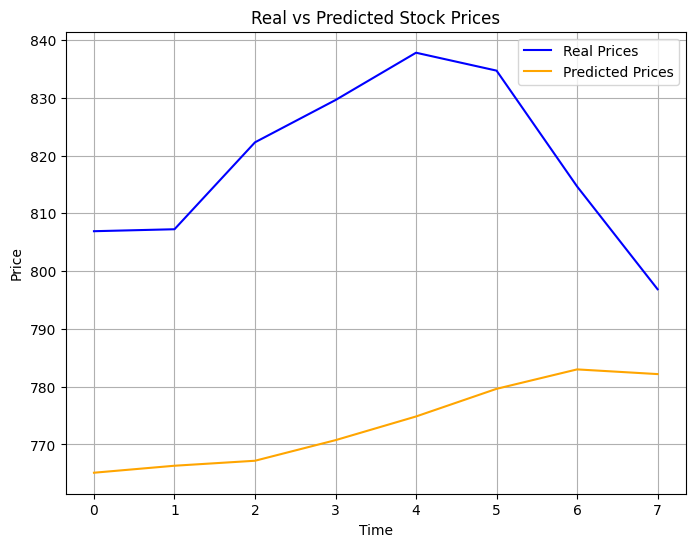

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to datasets
train_path = '/content/drive/MyDrive/code/Google_Stock_Price_Train.csv'
test_path = '/content/drive/MyDrive/code/Google_Stock_Price_Test.csv'

# Load training and testing data
train_data = pd.read_csv(train_path, parse_dates=['Date'], index_col="Date")
test_data = pd.read_csv(test_path, parse_dates=['Date'], index_col="Date")

# Select the column for modeling
train_values = train_data[['Open']].values  # Using "Open" price as the target
test_values = test_data[['Open']].values

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Split the training data into training and validation sets
train_size = int(len(train_scaled) * 0.8)
train_data_split = train_scaled[:train_size]
val_data_split = train_scaled[train_size:]

# Define TimeseriesGenerator parameters
sequence_length = 12  # Number of past steps to consider
batch_size = 16

# Create generators for training, validation, and testing
train_generator = TimeseriesGenerator(train_data_split, train_data_split, length=sequence_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(val_data_split, val_data_split, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=sequence_length, batch_size=batch_size)

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dropout(0.2),
    Dense(1)  # Single output for predicting the next "Open" price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1
)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Save the model
model.save('google_stock_lstm_with_validation.h5')
print("Model saved as 'google_stock_lstm_with_validation.h5'.")

# Predict future values
predictions = model.predict(test_generator)

# Rescale the predictions back to the original scale
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(test_scaled[sequence_length:])

# Plot real vs. predicted prices
plt.figure(figsize=(8, 6))
plt.plot(real_prices, label='Real Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange')
plt.title('Real vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
